# Photo-z with torch implementation of ViT

In [18]:
import torch
from vit_pytorch import ViT
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tools import *

In [2]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-4
gamma = 0.7
seed = 111

### Data

In [3]:
img = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/img_30k.npy')
z = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/z_30k.npy')

In [4]:
# Scaling the images
from scipy.stats import median_abs_deviation

scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)
    
def preprocessing(image):
    return np.arcsinh(img / scaling / 3. )

img = preprocessing(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


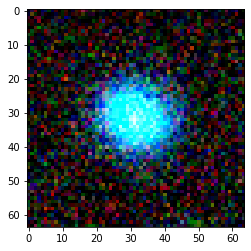

In [5]:
# Check transformed images
plt.imshow(img[0, ..., :3]);

Shapes of images in torch need to be organised differently from (number, width, height, depth) to (number, depth, width, height)

In [6]:
img = torch.transpose(torch.transpose(torch.tensor(img), 2,3), 1, 2)

In [7]:
img.shape

torch.Size([30000, 5, 64, 64])

### Loader without Dataset

In [8]:
# Converting train, val and test image data into tensors
train_X_tensor = img[:15000].to(torch.float32)
val_X_tensor = img[15000:20000].to(torch.float32)
test_X_tensor = img[20000:].to(torch.float32)

# Converting train and val labels into tensors
train_y_tensor = torch.tensor(z[:15000]).to(torch.float32)
val_y_tensor = torch.tensor(z[15000:20000]).to(torch.float32)

# Creating train  and val tensors
train_tensor = TensorDataset(train_X_tensor, train_y_tensor)
val_tensor = TensorDataset(val_X_tensor, val_y_tensor)

In [9]:
batch_size = 64
train_loader = DataLoader(dataset = train_tensor, batch_size=batch_size)
val_loader = DataLoader(dataset = val_tensor, batch_size=batch_size)

### Model

In [10]:
model = ViT(
    dim=256,
    image_size=64,
    patch_size=16,
    num_classes=1,
    depth=6,
    heads=16,
    mlp_dim=512,
    channels=5,
    pool='mean')

### Training

In [11]:
# loss function
criterion = nn.MSELoss()
# optimizer
lr = 3e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
epochs = 15
losses = {'train':[],
          'val':[]}

for epoch in range(epochs):
    epoch_loss = 0
    for data, label in tqdm(train_loader):
        model.train()
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, label)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss / len(train_loader)
        
    with torch.no_grad():
        model.eval()
        epoch_val_loss = 0
        for data, label in val_loader:
            val_output = model(data).squeeze()
            val_loss = criterion(val_output, label)
            epoch_val_loss += val_loss / len(val_loader)
            
    scheduler.step()

    losses['train'].append(epoch_loss.detach()), losses['val'].append(epoch_val_loss.detach())
    print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f}\n")

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.1016 - val_loss : 0.0092



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0082 - val_loss : 0.0068



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0049 - val_loss : 0.0031



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0027 - val_loss : 0.0026



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0022 - val_loss : 0.0024



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0020 - val_loss : 0.0024



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0019 - val_loss : 0.0024



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0019 - val_loss : 0.0023



  0%|          | 0/235 [00:00<?, ?it/s]

In [19]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\n Number of parameters: {count_parameters(model)}')


 Number of parameters: 8212993


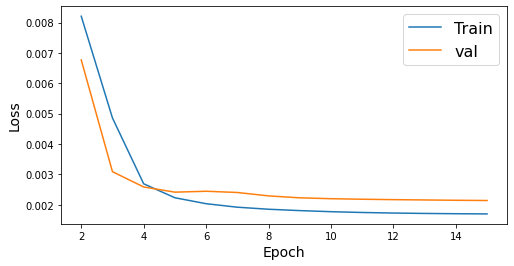

In [20]:
epoch = np.arange(2, epochs+1)
plt.figure(figsize=(8,4))
plt.plot(epoch, losses['train'][1:], label='Train')
plt.plot(epoch, losses['val'][1:], label='val')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', prop = { "size": 16 });

### Results

In [21]:
# Get the prediction
preds = model(test_X_tensor).detach().numpy().squeeze()

In [22]:
# Metrics results
dz, pred_bias, smad, out_frac = metrics(z[20000:], preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0009


<IPython.core.display.Latex object>

Outlier fraction: 13.32%


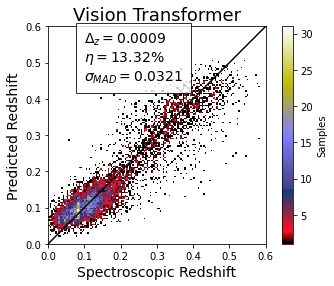

In [23]:
plot_results(z[20000:], preds, pred_bias, out_frac, smad, 'Vision Transformer')